# Classifiers

In [1]:
import sys
sys.path.insert(0, "../")

import torch
import pandas as pd
pd.set_option("display.precision", 4)

from datasets import get_dataset
from attacks import fgsm, ifgsm
from torch.utils.data import DataLoader
from utils import load_model

classifiers = {
    'svhn': load_model(r'..\runs\svhn\cls-svhn'),
    'mnist': load_model(r'..\runs\mnist\cls-mnist'),
    'cifar10': load_model(r'..\runs\cifar10\cls-cifar'),
    'mnist_natural': load_model(r'..\runs\mnist\pretrained', 'mnist.py', 'mnist_natural.pth'),
    'mnist_robust': load_model(r'..\runs\mnist\pretrained', 'mnist.py', 'mnist_adv.pth'),
}

### Performance overview

In [2]:
%%time
attacks = ['No adversary', 'FGSM 0.1', 'FGSM 0.2', 'iFGSM 0.1', 'iFGSM 0.2']

acc = {}
for name, model in classifiers.items():
    dataset_name = name.split('_')[0]
    dataset = get_dataset(dataset_name, train=False)
    acc[name] = {}
    
    for attack in attacks:
        print(f'Model: \t {name}: \t Attack: {attack}')
        no_correct = 0
        loader = DataLoader(dataset, 1024)
        for batch, label in loader:
            batch, label = batch.to('cuda'), label.to('cuda')
            
            method, epsilon = attack.split(' ')
            if method == 'FGSM':
                batch = fgsm(batch, label, model.net, float(epsilon))
            elif method == 'iFGSM':
                batch = ifgsm(batch, label, model.net, float(epsilon))

            with torch.no_grad():
                output = model.net(batch)
                predictions = output.data.argmax(dim=1)
                no_correct += predictions.eq(label).sum().item()
        acc[name][attack] = no_correct / len(dataset)

Model: 	 svhn: 	 Attack: No adversary
Model: 	 svhn: 	 Attack: FGSM 0.1
Model: 	 svhn: 	 Attack: FGSM 0.2
Model: 	 svhn: 	 Attack: iFGSM 0.1
Model: 	 svhn: 	 Attack: iFGSM 0.2
Model: 	 mnist: 	 Attack: No adversary
Model: 	 mnist: 	 Attack: FGSM 0.1
Model: 	 mnist: 	 Attack: FGSM 0.2
Model: 	 mnist: 	 Attack: iFGSM 0.1
Model: 	 mnist: 	 Attack: iFGSM 0.2
Model: 	 cifar10: 	 Attack: No adversary
Model: 	 cifar10: 	 Attack: FGSM 0.1
Model: 	 cifar10: 	 Attack: FGSM 0.2
Model: 	 cifar10: 	 Attack: iFGSM 0.1
Model: 	 cifar10: 	 Attack: iFGSM 0.2
Model: 	 mnist_natural: 	 Attack: No adversary
Model: 	 mnist_natural: 	 Attack: FGSM 0.1
Model: 	 mnist_natural: 	 Attack: FGSM 0.2
Model: 	 mnist_natural: 	 Attack: iFGSM 0.1
Model: 	 mnist_natural: 	 Attack: iFGSM 0.2
Model: 	 mnist_robust: 	 Attack: No adversary
Model: 	 mnist_robust: 	 Attack: FGSM 0.1
Model: 	 mnist_robust: 	 Attack: FGSM 0.2
Model: 	 mnist_robust: 	 Attack: iFGSM 0.1
Model: 	 mnist_robust: 	 Attack: iFGSM 0.2
Wall time: 13mi

In [8]:
df = pd.DataFrame(acc)
df.T

,No adversary,FGSM 0.1,FGSM 0.2,iFGSM 0.1,iFGSM 0.2
svhn,0.9537,0.1675,0.1021,0.0025,0.0000
mnist,0.9950,0.7367,0.2657,0.2757,0.0008
cifar10,0.8572,0.0746,0.0885,0.0000,0.0000
mnist_natural,0.9917,0.8444,0.5710,0.5876,0.0525
mnist_robust,0.9840,0.9795,0.9710,0.9556,0.8536


# Generative

In [27]:
import sys
sys.path.insert(0, "../")

import os
import pandas as pd
import numpy as np
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)

from datasets import get_dataset
from metrics import swd_metric, is_metric
from logger import GenerativeSummary
from utils import class_sampler, grid_plot, load_args, load_model
root = '..\\runs'

classifiers = {
    'svhn': load_model(r'..\runs\svhn\cls-svhn'),
    'mnist': load_model(r'..\runs\\mnist\cls-mnist'),
    'cifar10': load_model(r'..\runs\\cifar10\cls-cifar'),
}


def evaluate(model, classifier, dataset, repeat=5):
    d={}
    
    # Inception score
    model.to('cuda')
    d['is_mean'] = []
    d['is_std'] = []
    summary = GenerativeSummary(get_dataset(dataset), model.size_z, seed=None)
    for i in range(repeat):
        mean, std = summary.inception_score(model.decode, classifier)
        d['is_mean'].append(mean)
        d['is_std'].append(std)
    
    # Sliced Wasserstein distance
    model.to('cpu')
    d['swd'] = []
    for i in range(repeat*2):
        summary = GenerativeSummary(get_dataset(dataset), model.size_z, seed=100+i)
        swd = summary.swd(model.decode)
        d['swd'].append(swd)
    model.to('cuda')
    return d

def dict_summary(input_dict):
    output = {}
    for key, value in input_dict.items():
        d = {}
        array = np.array(value['is_mean'])
        d['is_mean'] = array.mean()
        d['is_std'] = array.std()
        d['is_min'] = array.min()
        d['is_max'] = array.max()

        stacked_array = torch.stack(value['swd']).numpy()
        for i in range(stacked_array.shape[1]):
            array = stacked_array[:, i]
            d[f'swd{i}_mean'] = array.mean()
            d[f'swd{i}_std'] = array.std()
            d[f'swd{i}_min'] = array.min()
            d[f'swd{i}_max'] = array.max()            
        output[key] = d
    return output

def sample_grid(classifier, model, nrow, threshold, device='cuda'):
    no_class = 10
    samples = {c: class_sampler(classifier, model, c, samples=nrow, threshold=threshold, device=device) for c in range(no_class)}
    samples = model.decode(torch.cat(list(samples.values())))
    grid = make_grid(samples, nrow=nrow, normalize=True)
    grid = grid.cpu().detach().numpy()
    grid = np.transpose(grid, (1,2,0))
    return grid

### MNIST

In [28]:
dataset = 'mnist'
classifier = classifiers[dataset].net


generative_mnist = {
    'ALI': load_model(f'{root}\\{dataset}\\ali-{dataset}'),
    'DCGAN': load_model(f'{root}\\{dataset}\\dcgan-{dataset}'),
    'VAE': load_model(f'{root}\\{dataset}\\vae-{dataset}'),
}

In [15]:
# Performance
d = {}
for name, model in generative_mnist.items():
    d[name] = evaluate(model, classifier, dataset=dataset)
df_mnist = pd.DataFrame(dict_summary(d)).T
df_mnist.sort_values('is_mean')

,is_mean,is_std,is_min,is_max,swd0_mean,swd0_std,swd0_min,swd0_max
VAE,8.7980,0.0149,8.7844,8.8227,0.2628,0.0079,0.2491,0.2737
DCGAN,9.4440,0.0061,9.4344,9.4505,0.0536,0.0126,0.0405,0.0807
ALI,9.5565,0.0060,9.5483,9.5652,0.0581,0.0180,0.0388,0.1093


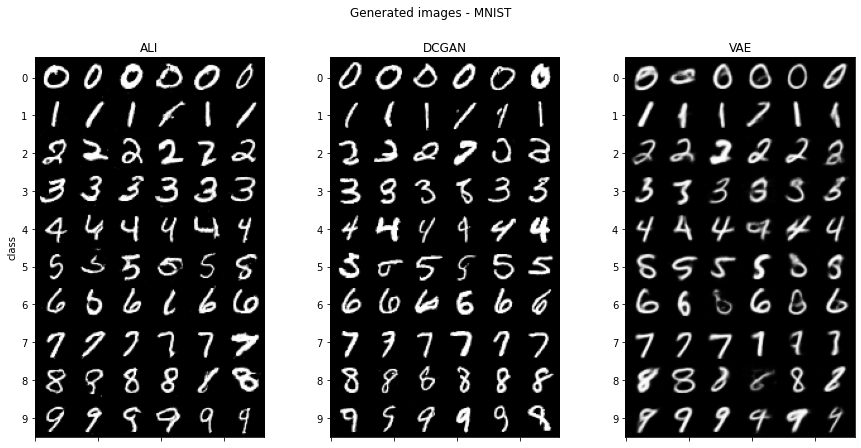

In [29]:
torch.manual_seed(1)

rows = 6
grid_ali = sample_grid(classifiers['mnist'], generative_mnist['ALI'], rows, 0.5)
grid_dcgan = sample_grid(classifiers['mnist'], generative_mnist['DCGAN'], rows, 0.5)
grid_vae = sample_grid(classifiers['mnist'], generative_mnist['VAE'], rows, 0.5)


fig = plt.figure(figsize=(15, 7))
fig.suptitle('Generated images - MNIST')

ax1 = fig.add_subplot(131)
ax1.title.set_text('ALI')
ax1.set_ylabel('class')
ax1.set_yticks(np.linspace(16, grid_ali.shape[0]-16, 10))
ax1.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax1.set_xticklabels([])
ax1.imshow(grid_ali)

ax2 = fig.add_subplot(132)
ax2.title.set_text('DCGAN')
ax2.set_yticks(np.linspace(16, grid_ali.shape[0]-16, 10))
ax2.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax2.set_xticklabels([])
ax2.imshow(grid_dcgan)


ax3 = fig.add_subplot(133)
ax3.title.set_text('VAE')
ax3.set_yticks(np.linspace(16, grid_ali.shape[0]-16, 10))
ax3.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax3.set_xticklabels([])
ax3.imshow(grid_vae)


plt.savefig('figures\\generated_mnist.png', bbox_inches='tight')
plt.show()

### SVHN

In [35]:
dataset = 'svhn'
classifier = classifiers[dataset].net

generative_svhn = {
    'ALI': load_model(f'{root}\\{dataset}\\ali-{dataset}'),
    'DCGAN': load_model(f'{root}\\{dataset}\\dcgan-{dataset}'),
    'VAE': load_model(f'{root}\\{dataset}\\vae-{dataset}'),
}

In [36]:
# Performance
d = {}
for name, model in generative_svhn.items():
    d[name] = evaluate(model, classifier, dataset=dataset)
df_svhn = pd.DataFrame(dict_summary(d)).T
df_svhn

,is_mean,is_std,is_min,is_max,swd0_mean,swd0_std,swd0_min,swd0_max,swd1_mean,swd1_std,swd1_min,swd1_max
ALI,8.0619,0.0041,8.0580,8.0675,0.1899,0.0122,0.1735,0.2156,0.3812,0.0716,0.2809,0.5207
DCGAN,8.0234,0.0102,8.0140,8.0424,0.2464,0.0999,0.1434,0.5056,0.2328,0.0451,0.1767,0.3031
VAE,7.3671,0.0141,7.3546,7.3879,0.9484,0.0591,0.8158,1.0347,0.3696,0.0699,0.2500,0.4953


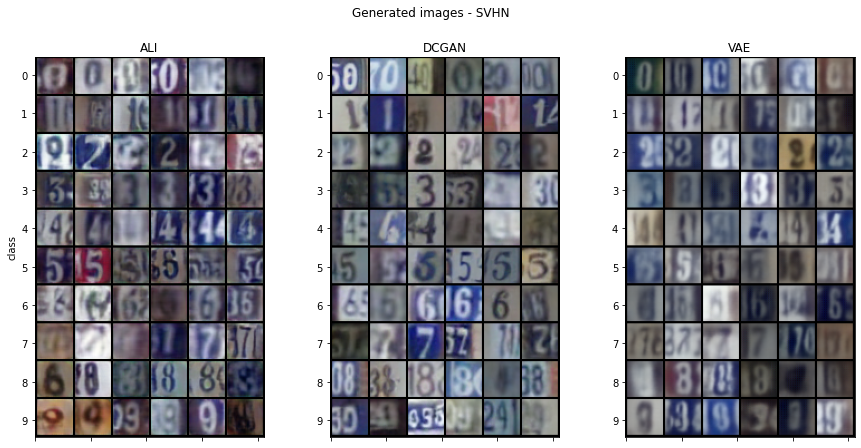

In [37]:
torch.manual_seed(1)

rows = 6
grid_ali = sample_grid(classifiers['svhn'], generative_svhn['ALI'], rows, 0.5)
grid_dcgan = sample_grid(classifiers['svhn'], generative_svhn['DCGAN'], rows, 0.5)
grid_vae = sample_grid(classifiers['svhn'], generative_svhn['VAE'], rows, 0.5)


fig = plt.figure(figsize=(15, 7))
fig.suptitle('Generated images - SVHN')

ax1 = fig.add_subplot(131)
ax1.title.set_text('ALI')
ax1.set_ylabel('class')
ax1.set_yticks(np.linspace(16, grid_ali.shape[0]-16, 10))
ax1.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax1.set_xticklabels([])
ax1.imshow(grid_ali)

ax2 = fig.add_subplot(132)
ax2.title.set_text('DCGAN')
ax2.set_yticks(np.linspace(16, grid_ali.shape[0]-16, 10))
ax2.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax2.set_xticklabels([])
ax2.imshow(grid_dcgan)


ax3 = fig.add_subplot(133)
ax3.title.set_text('VAE')
ax3.set_yticks(np.linspace(16, grid_ali.shape[0]-16, 10))
ax3.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax3.set_xticklabels([])
ax3.imshow(grid_vae)


plt.savefig('figures\\generated_svhn.png', bbox_inches='tight')
plt.show()

### CIFAR10

In [38]:
dataset = 'cifar10'
classifier = classifiers[dataset].net

generative_cifar = {
    'ALI': load_model(f'{root}\\{dataset}\\ali-cifar'),
    'DCGAN': load_model(f'{root}\\{dataset}\\dcgan-cifar'),
    'VAE (beta=1)': load_model(f'{root}\\{dataset}\\vae-cifar_blurry'),
    'VAE (beta=0.1)': load_model(f'{root}\\{dataset}\\vae-cifar_sharp'),
}

In [39]:
# Performance
d = {}
for name, model in generative_cifar.items():
    d[name] = evaluate(model, classifier, dataset=dataset)
df_cifar = pd.DataFrame(dict_summary(d)).T
df_cifar

,is_mean,is_std,is_min,is_max,swd0_mean,swd0_std,swd0_min,swd0_max,swd1_mean,swd1_std,swd1_min,swd1_max
ALI,6.8786,0.0066,6.8735,6.8916,0.1270,0.0129,0.1054,0.1484,0.2949,0.0459,0.1920,0.3543
DCGAN,6.8181,0.0147,6.8020,6.8405,0.1559,0.0160,0.1310,0.1918,0.2587,0.0249,0.2288,0.3015
VAE (beta=1),3.1773,0.0041,3.1698,3.1816,1.0474,0.0408,0.9740,1.1129,0.3725,0.0585,0.2938,0.5158
VAE (beta=0.1),3.5606,0.0119,3.5481,3.5771,0.8770,0.0314,0.8228,0.9399,0.5635,0.0585,0.4625,0.6763


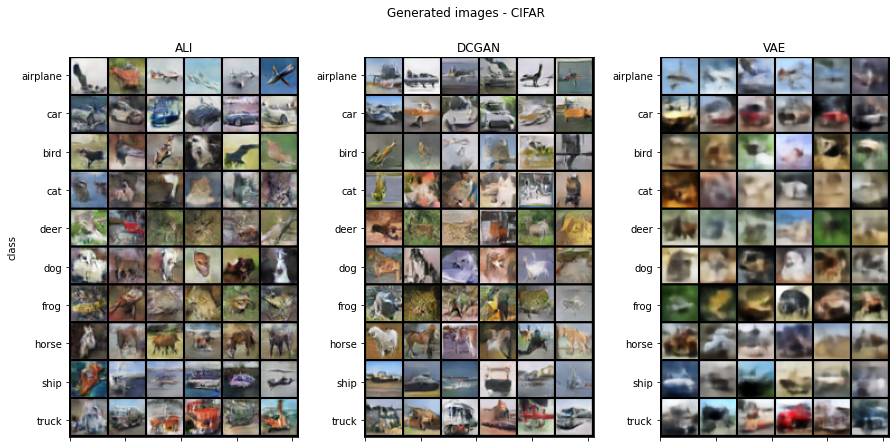

In [40]:
torch.manual_seed(1)

rows = 6
threshold = 0.5
grid_ali = sample_grid(classifiers['cifar10'], generative_cifar['ALI'], rows, threshold)
grid_dcgan = sample_grid(classifiers['cifar10'], generative_cifar['DCGAN'], rows, threshold)
grid_vae_blurry = sample_grid(classifiers['cifar10'], generative_cifar['VAE (beta=1)'], rows, threshold)
grid_vae_sharp = sample_grid(classifiers['cifar10'], generative_cifar['VAE (beta=0.1)'], rows, threshold)

fig = plt.figure(figsize=(15, 7))
fig.suptitle('Generated images - CIFAR')

ax1 = fig.add_subplot(131)
ax1.title.set_text('ALI')
ax1.set_ylabel('class')
ax1.set_yticks(np.linspace(16, grid_ali.shape[0]-16, 10))
ax1.set_yticklabels(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
ax1.set_xticklabels([])
ax1.imshow(grid_ali)

ax2 = fig.add_subplot(132)
ax2.title.set_text('DCGAN')
ax2.set_yticks(np.linspace(16, grid_ali.shape[0]-16, 10))
ax2.set_yticklabels(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
ax2.set_xticklabels([])
ax2.imshow(grid_dcgan)

ax3 = fig.add_subplot(133)
ax3.title.set_text('VAE')
ax3.set_yticks(np.linspace(16, grid_ali.shape[0]-16, 10))
ax3.set_yticklabels(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
ax3.set_xticklabels([])
ax3.imshow(grid_vae_blurry)

plt.savefig('figures\\generated_cifar.png', bbox_inches='tight')
plt.show()